In [1]:
import pandas as pd
import os
import warnings
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
path = r'/Users/kirik/Documents/diplom hse/data/'

# Функции

In [2]:
def check_and_remove_duplicates(df):
    """
    Функция для проверки на дубли и удаления.
    
    Параметры:
    df (pandas.DataFrame): Датасет.
    
    Возвращает:
    pandas.DataFrame: Датасет после удаления дублей.
    """
    # Проверяем наличие дублей по столбцам 'id' и 'date'
    duplicates = df[df.duplicated(subset=['smt_building_addressid', 'report_date'])]
    
    if not duplicates.empty:
        print("Найдены дубли:")
        print(duplicates)
        
        # Количество дублей
        num_duplicates = duplicates.shape[0]
        print(f"\nКоличество удалённых дублей: {num_duplicates}")
        
        # Удаляем дубли по столбцам 'id' и 'date'
        df.drop_duplicates(subset=['smt_building_addressid', 'report_date'], inplace=True)
        
    else:
        print("Дубли не найдены.")
    
    return df


In [3]:
def drop_columns_with_many_nans(df, threshold=0.7):
    """
    Удаляет столбцы с долей пропущенных значений >= threshold.
    """
    null_fraction = df.isnull().mean()
    cols_to_drop = null_fraction[null_fraction >= threshold].index
    df.drop(columns=cols_to_drop, inplace=True)
    print(f'Удалено столбцов: {len(cols_to_drop)}')


In [4]:
def replace_outliers_with_nan(df):
    outlier_columns_count = 0  # Счетчик столбцов с выбросами
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Проверяем, что колонка числовая
            # Вычисление 0.05 и 0.95 квантилей
            Q1 = df[col].quantile(0.05)
            Q3 = df[col].quantile(0.95)

            IQR = Q3 - Q1
            
            # Определяем нижний и верхний пределы для выбросов
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Замена выбросов на NaN в векторизованном виде
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            # Проверка наличия выбросов в столбце
            if outliers.any():
                outlier_columns_count += 1
            
            # Замена выбросов на NaN
            df.loc[outliers, col] = np.nan
    
    # Выводим количество столбцов с выбросами
    print(f"Количество столбцов с выбросами: {outlier_columns_count}")
    return df


In [5]:
def analyze_and_clean_features(df, target_column, threshold=0.7):
    """
    Функция для анализа корреляции признаков с таргетом, вывода топ-20 признаков с самой высокой корреляцией
    и удаления признаков с корреляцией выше порогового значения.
    
    :param df: DataFrame с данными
    :param target_column: строка, имя таргетного столбца для корреляции
    :param threshold: порог для корреляции, выше которого признаки будут удалены (по умолчанию 0.7)
    :return: очищенный DataFrame
    """
    # 1. Фильтруем только числовые столбцы
    numerical_df = df.select_dtypes(include=['number'])
    
    # 2. Вычислим корреляцию между признаками и таргетом
    correlation_with_target = numerical_df.corr()[target_column].drop(target_column)
    
    # 3. Выведем топ-20 признаков с самой высокой корреляцией с таргетом
    top_20_features = correlation_with_target.abs().sort_values(ascending=False).head(20)
    print("Топ-20 признаков, которые наиболее коррелируют с таргетом:")
    print(top_20_features)
    
    # 4. Определим признаки, которые нужно удалить (с корреляцией выше порога)
    to_drop = correlation_with_target[abs(correlation_with_target) > threshold].index
    
    # 5. Удалим эти признаки из DataFrame
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned


# Загрузка данных

In [7]:
df_building_description = pd.read_csv(path+'df_building_description.csv', parse_dates=['smt_delivery_date']).rename(columns={'smt_delivery_date':'report_date'})
print(df_building_description.shape)
df_building_description.head(3)

(640, 12)


,smt_building_addressid,smt_construction_projectid,smt_queuecode,smt_stagecode,is_apartments,smt_section_quantity,smt_floor_quantity,smt_lower_floor,smt_upper_floor,smt_total_building_area,smt_land_area,report_date
0,5CC30C3F-5B05-EA11-80ED-005056B8D207,6DA279E4-2805-EA11-80ED-005056B8D207,100000001,100000001,1,1,24,1,24,66531.704894,16070.0,2023-06-30
1,601548AB-7E14-E711-80C1-005056B8D207,E48F6C85-7414-E711-80C1-005056B8D207,100000003,100000001,0,7,17,1,17,NaN,NaN,2018-02-28
2,6B29FD57-5C83-E811-80DE-005056B8D207,9C3B7E8F-941C-E811-80DD-005056B8D207,100000003,100000001,0,2,11,1,11,43108.879407,19099.0,2021-05-31


In [8]:
df_neighbours_features = pd.read_csv(path+'df_neighbours_features.csv', parse_dates=['report_date'])
print(df_neighbours_features.shape)
df_neighbours_features.head(3)

(1635, 79)


,smt_construction_projectid,report_date,intmap_expon_area,intmap_expon_cost,sales__g_house__area__sum__2_2M,sales__g_house__area__sum__2_3M,sales__g_house__area__sum__2_600M,sales__g_house__area__avg__2_2M,sales__g_house__area__avg__2_3M,sales__g_house__area__avg__2_600M,sales__g_house__rooms__sum__2_2M,sales__g_house__rooms__sum__2_3M,sales__g_house__rooms__sum__2_600M,sales__g_house__rooms__avg__2_2M,sales__g_house__rooms__avg__2_3M,sales__g_house__rooms__avg__2_600M,neighbours_info__g_house__floor_min__radius_500m__avg,neighbours_info__g_house__floor_min__radius_1km__avg,neighbours_info__g_house__floor_min__radius_3km__avg,neighbours_info__g_house__floor_max__radius_500m__avg,neighbours_info__g_house__floor_max__radius_1km__avg,neighbours_info__g_house__floor_max__radius_3km__avg,neighbours_info__g_house__days_to_finish__radius_500m__avg,neighbours_info__g_house__days_to_finish__radius_1km__avg,neighbours_info__g_house__days_to_finish__radius_3km__avg,neighbours_info__g_house__flats_per_floor__radius_500m__avg,neighbours_info__g_house__flats_per_floor__radius_1km__avg,neighbours_info__g_house__flats_per_floor__radius_3km__avg,neighbours_info__g_house__sections_qty__radius_500m__avg,neighbours_info__g_house__sections_qty__radius_1km__avg,neighbours_info__g_house__sections_qty__radius_3km__avg,neighbours_info__g_house__first_floor_non_liv__radius_500m__avg,neighbours_info__g_house__first_floor_non_liv__radius_1km__avg,neighbours_info__g_house__first_floor_non_liv__radius_3km__avg,neighbours_info__g_house__transport_index__radius_500m__avg,neighbours_info__g_house__transport_index__radius_1km__avg,neighbours_info__g_house__transport_index__radius_3km__avg,neighbours_info__g_house__green_index__radius_500m__avg,neighbours_info__g_house__green_index__radius_1km__avg,neighbours_info__g_house__green_index__radius_3km__avg,neighbours_info__g_house__air_index__radius_500m__avg,neighbours_info__g_house__air_index__radius_1km__avg,neighbours_info__g_house__air_index__radius_3km__avg,neighbours_info__g_house__finish_type_eq_bezotdelki__radius_500m__avg,neighbours_info__g_house__finish_type_eq_bezotdelki__radius_1km__avg,neighbours_info__g_house__finish_type_eq_bezotdelki__radius_3km__avg,neighbours_info__g_house__finish_type_eq_podchistovuyu__radius_500m__avg,neighbours_info__g_house__finish_type_eq_podchistovuyu__radius_1km__avg,neighbours_info__g_house__finish_type_eq_podchistovuyu__radius_3km__avg,neighbours_info__g_house__finish_type_eq_pozhelaniyuzakazchika__radius_500m__avg,neighbours_info__g_house__finish_type_eq_pozhelaniyuzakazchika__radius_1km__avg,neighbours_info__g_house__finish_type_eq_pozhelaniyuzakazchika__radius_3km__avg,neighbours_info__g_house__finish_type_eq_podklyuch__radius_500m__avg,neighbours_info__g_house__finish_type_eq_podklyuch__radius_1km__avg,neighbours_info__g_house__finish_type_eq_podklyuch__radius_3km__avg,neighbours_info__g_house__finish_type_eq_drugoe__radius_500m__avg,neighbours_info__g_house__finish_type_eq_drugoe__radius_1km__avg,neighbours_info__g_house__finish_type_eq_drugoe__radius_3km__avg,house_info__g_house__floor_min__avg,house_info__g_house__floor_max__avg,house_info__g_house__flats_qty__avg,house_info__g_house__days_to_finish__avg,house_info__g_house__car_places_qty__avg,house_info__g_house__power__avg,house_info__g_house__latitude__avg,house_info__g_house__longitude__avg,house_info__g_house__com_places_qty__avg,house_info__g_house__flats_per_floor__avg,house_info__g_house__sections_qty__avg,house_info__g_house__parking__avg,house_info__g_house__first_floor_non_liv__avg,house_info__g_house__transport_index__avg,house_info__g_house__green_index__avg,house_info__g_house__air_index__avg,house_info__g_house__finish_type_eq_bezotdelki__avg,house_info__g_house__finish_type_eq_podchistovuyu__avg,house_info__g_house__finish_type_eq_pozhelaniyuzakazchika__avg,house_info__g_house__finish_type_eq_podklyuch__avg,house_info__g_house__finish_type_eq_drugoe__avg
0,6DA279E4-2805-EA11-80ED-005056B8D207,2022

In [9]:
df_project_features = pd.read_csv(path+'df_project_features.csv', parse_dates=['report_date'])
print(df_project_features.shape)
df_project_features.head(3)

(1635, 126)


,smt_construction_projectid,report_date,calls__g_project__calls_num__sum__1M,calls__g_project__calls_num__sum__3M,calls__g_project__calls_num__sum__6M,calls__g_project__calls_num__sum__12M,calls__g_project__calls_num_norm__sum__1M,calls__g_project__calls_num_norm__sum__3M,calls__g_project__calls_num_norm__sum__6M,calls__g_project__calls_num_norm__sum__12M,appointments__g_project__appointments_num__sum__1M,appointments__g_project__appointments_num__sum__3M,appointments__g_project__appointments_num__sum__6M,appointments__g_project__appointments_num__sum__12M,appointments__g_project__appointments_num_norm__sum__1M,appointments__g_project__appointments_num_norm__sum__3M,appointments__g_project__appointments_num_norm__sum__6M,appointments__g_project__appointments_num_norm__sum__12M,sales__g_project__area__sum__2_2M,sales__g_project__area__sum__2_3M,sales__g_project__area__sum__2_600M,sales__g_project__area__avg__2_2M,sales__g_project__area__avg__2_3M,sales__g_project__area__avg__2_600M,sales__g_project__rooms__sum__2_2M,sales__g_project__rooms__sum__2_3M,sales__g_project__rooms__sum__2_600M,sales__g_project__rooms__avg__2_2M,sales__g_project__rooms__avg__2_3M,sales__g_project__rooms__avg__2_600M,neighbours_expon__g_project__price__radius_500m__avg__1_1M,neighbours_expon__g_project__price__radius_1km__avg__1_1M,neighbours_expon__g_project__price__radius_3km__avg__1_1M,neighbours_expon__g_project__price__radius_500m__avg__1_2M,neighbours_expon__g_project__price__radius_1km__avg__1_2M,neighbours_expon__g_project__price__radius_3km__avg__1_2M,neighbours_expon__g_project__price__radius_500m__avg__1_3M,neighbours_expon__g_project__price__radius_1km__avg__1_3M,neighbours_expon__g_project__price__radius_3km__avg__1_3M,neighbours_expon__g_project__price__radius_500m__sum__1_1M,neighbours_expon__g_project__price__radius_1km__sum__1_1M,neighbours_expon__g_project__price__radius_3km__sum__1_1M,neighbours_expon__g_project__price__radius_500m__sum__1_2M,neighbours_expon__g_project__price__radius_1km__sum__1_2M,neighbours_expon__g_project__price__radius_3km__sum__1_2M,neighbours_expon__g_project__price__radius_500m__sum__1_3M,neighbours_expon__g_project__price__radius_1km__sum__1_3M,neighbours_expon__g_project__price__radius_3km__sum__1_3M,neighbours_expon__g_project__area__radius_500m__avg__1_1M,neighbours_expon__g_project__area__radius_1km__avg__1_1M,neighbours_expon__g_project__area__radius_3km__avg__1_1M,neighbours_expon__g_project__area__radius_500m__avg__1_2M,neighbours_expon__g_project__area__radius_1km__avg__1_2M,neighbours_expon__g_project__area__radius_3km__avg__1_2M,neighbours_expon__g_project__area__radius_500m__avg__1_3M,neighbours_expon__g_project__area__radius_1km__avg__1_3M,neighbours_expon__g_project__area__radius_3km__avg__1_3M,neighbours_expon__g_project__area__radius_500m__sum__1_1M,neighbours_expon__g_project__area__radius_1km__sum__1_1M,neighbours_expon__g_project__area__radius_3km__sum__1_1M,neighbours_expon__g_project__area__radius_500m__sum__1_2M,neighbours_expon__g_project__area__radius_1km__sum__1_2M,neighbours_expon__g_project__area__radius_3km__sum__1_2M,neighbours_expon__g_project__area__radius_500m__sum__1_3M,neighbours_expon__g_project__area__radius_1km__sum__1_3M,neighbours_expon__g_project__area__radius_3km__sum__1_3M,neighbours_sales__g_project__area__radius_500m__avg__2_2M,neighbours_sales__g_project__area__radius_1km__avg__2_2M,neighbours_sales__g_project__area__radius_3km__avg__2_2M,neighbours_sales__g_project__area__radius_500m__avg__2_3M,neighbours_sales__g_project__area__radius_1km__avg__2_3M,neighbours_sales__g_project__area__radius_3km__avg__2_3M,neighbours_sales__g_project__area__radius_500m__avg__2_600M,neighbours_sales__g_project__area__radius_1km__avg__2_600M,neighbours_sales__g_project__area__radius_3km__avg__2_600M,neighbours_sales__g_project__area__radius_500m__sum__2_2M,neighbours_sales__g_project__area__radius_1km__sum__2_2M,neighbours_sales__g_project__area__radius_3km__sum__2_2M,neighbours_sal

In [10]:
df_building_features = pd.read_csv(path+'df_building_features.csv', parse_dates=['report_date'])
print(df_building_features.shape)
df_building_features.head(3)

(16903, 886)


,smt_building_addressid,report_date,area__g_building__smt_projected_total_area__count,area__g_building__smt_projected_total_area__rooms_0__count,area__g_building__smt_projected_total_area__rooms_1__count,area__g_building__smt_projected_total_area__rooms_2__count,area__g_building__smt_projected_total_area__rooms_3plus__count,area__g_building__smt_projected_total_area__avg,area__g_building__smt_projected_total_area__rooms_0__avg,area__g_building__smt_projected_total_area__rooms_1__avg,area__g_building__smt_projected_total_area__rooms_2__avg,area__g_building__smt_projected_total_area__rooms_3plus__avg,area__g_building__smt_projected_total_area__sum,area__g_building__smt_projected_total_area__rooms_0__sum,area__g_building__smt_projected_total_area__rooms_1__sum,area__g_building__smt_projected_total_area__rooms_2__sum,area__g_building__smt_projected_total_area__rooms_3plus__sum,area__g_building__smt_projected_total_area__max,area__g_building__smt_projected_total_area__rooms_0__max,area__g_building__smt_projected_total_area__rooms_1__max,area__g_building__smt_projected_total_area__rooms_2__max,area__g_building__smt_projected_total_area__rooms_3plus__max,area__g_building__smt_projected_total_area__min,area__g_building__smt_projected_total_area__rooms_0__min,area__g_building__smt_projected_total_area__rooms_1__min,area__g_building__smt_projected_total_area__rooms_2__min,area__g_building__smt_projected_total_area__rooms_3plus__min,area__g_building__smt_projected_total_area__str_r__sum,area__g_building__smt_projected_total_area__free__sum,area__g_building__smt_projected_total_area__reserved__sum,area__g_building__smt_projected_total_area__sold__sum,area__g_building__smt_projected_total_area__rooms_0_str_r__sum,area__g_building__smt_projected_total_area__rooms_1_str_r__sum,area__g_building__smt_projected_total_area__rooms_2_str_r__sum,area__g_building__smt_projected_total_area__rooms_3plus_str_r__sum,area__g_building__smt_projected_total_area__rooms_0_free__sum,area__g_building__smt_projected_total_area__rooms_1_free__sum,area__g_building__smt_projected_total_area__rooms_2_free__sum,area__g_building__smt_projected_total_area__rooms_3plus_free__sum,area__g_building__smt_projected_total_area__rooms_0_reserved__sum,area__g_building__smt_projected_total_area__rooms_1_reserved__sum,area__g_building__smt_projected_total_area__rooms_2_reserved__sum,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,area__g_building__smt_projected_total_area__rooms_0_sold__sum,area__g_building__smt_projected_total_area__rooms_1_sold__sum,area__g_building__smt_projected_total_area__rooms_2_sold__sum,area__g_building__smt_projected_total_area__rooms_3plus_sold__sum,area__g_building__smt_projected_total_area__short_reservation__sum,area__g_building__smt_projected_total_area__long_reservation__sum,area__g_building__smt_projected_total_area__fintech_reservation__sum,area__g_building__smt_projected_total_area__long_fintech_reservation__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__fintech_reservation_end_next_month__sum,area__g_building__smt_projected_total_area__str_r__count,area__g_building__smt_projected_total_area__free__count,area__g_building__smt_projected_total_area__reserved__count,area__g_building__smt_projected_total_area__sold__count,area__g_building__smt_projected_total_area__rooms_0_str_r__count,area__g_building__smt_projected_total_area__rooms_1_str_r__count,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count,area__g_building__smt_projected_total_area__rooms_0_free__count,area__g_building__smt_projected_total_area__rooms_1_free__count,area__g_building__smt_projected_total_area__rooms_2_free__count,area__g_building__smt_projected_total_area__rooms_3plus_free__count,area__g_building__smt_projected_total_area__rooms_0_reserved__count,area__g_building__smt_projected_total_area__room

In [11]:
df_macro_features = pd.read_csv(path+'df_macro_features.csv', parse_dates=['report_date'])
print(df_macro_features.shape)
df_macro_features.head(3)

(33, 264)


,report_date,cbr__g_rd__key_rate__avg__1M,cbr__g_rd__key_rate__avg__3M,cbr__g_rd__key_rate__avg__12M,cbr__g_rd__key_rate__max__1M,cbr__g_rd__key_rate__max__3M,cbr__g_rd__key_rate__max__12M,cbr__g_rd__key_rate__min__1M,cbr__g_rd__key_rate__min__3M,cbr__g_rd__key_rate__min__12M,cbr__g_rd__key_rate__last2avg__1M,cbr__g_rd__key_rate__last2avg__3M,cbr__g_rd__key_rate__last2avg__12M,cbr__g_rd__key_rate__last2max__1M,cbr__g_rd__key_rate__last2max__3M,cbr__g_rd__key_rate__last2max__12M,cbr__g_rd__key_rate__last2min__1M,cbr__g_rd__key_rate__last2min__3M,cbr__g_rd__key_rate__last2min__12M,cbr__g_rd__key_rate__stddev__1M,cbr__g_rd__key_rate__stddev__3M,cbr__g_rd__key_rate__stddev__12M,cbr__g_rd__key_rate__last__1M,cbr__g_rd__key_rate__last__3M,cbr__g_rd__key_rate__last__12M,cbr__g_rd__usd_rub_rate__avg__1M,cbr__g_rd__usd_rub_rate__avg__3M,cbr__g_rd__usd_rub_rate__avg__12M,cbr__g_rd__usd_rub_rate__max__1M,cbr__g_rd__usd_rub_rate__max__3M,cbr__g_rd__usd_rub_rate__max__12M,cbr__g_rd__usd_rub_rate__min__1M,cbr__g_rd__usd_rub_rate__min__3M,cbr__g_rd__usd_rub_rate__min__12M,cbr__g_rd__usd_rub_rate__last2avg__1M,cbr__g_rd__usd_rub_rate__last2avg__3M,cbr__g_rd__usd_rub_rate__last2avg__12M,cbr__g_rd__usd_rub_rate__last2max__1M,cbr__g_rd__usd_rub_rate__last2max__3M,cbr__g_rd__usd_rub_rate__last2max__12M,cbr__g_rd__usd_rub_rate__last2min__1M,cbr__g_rd__usd_rub_rate__last2min__3M,cbr__g_rd__usd_rub_rate__last2min__12M,cbr__g_rd__usd_rub_rate__stddev__1M,cbr__g_rd__usd_rub_rate__stddev__3M,cbr__g_rd__usd_rub_rate__stddev__12M,cbr__g_rd__usd_rub_rate__last__1M,cbr__g_rd__usd_rub_rate__last__3M,cbr__g_rd__usd_rub_rate__last__12M,rosstat_q__g_rd__amount_housing_loans_resident__avg__1_1Q,rosstat_q__g_rd__amount_housing_loans_resident__avg__1_4Q,rosstat_q__g_rd__amount_housing_loans_resident__avg__1_8Q,rosstat_q__g_rd__amount_loans_resident__avg__1_1Q,rosstat_q__g_rd__amount_loans_resident__avg__1_4Q,rosstat_q__g_rd__amount_loans_resident__avg__1_8Q,rosstat_q__g_rd__amount_mortgage_loans_equity_agr_resident__avg__1_1Q,rosstat_q__g_rd__amount_mortgage_loans_equity_agr_resident__avg__1_4Q,rosstat_q__g_rd__amount_mortgage_loans_equity_agr_resident__avg__1_8Q,rosstat_q__g_rd__amount_mortgage_loans_resident__avg__1_1Q,rosstat_q__g_rd__amount_mortgage_loans_resident__avg__1_4Q,rosstat_q__g_rd__amount_mortgage_loans_resident__avg__1_8Q,rosstat_q__g_rd__avg_rate_housing_loans_resident__avg__1_1Q,rosstat_q__g_rd__avg_rate_housing_loans_resident__avg__1_4Q,rosstat_q__g_rd__avg_rate_housing_loans_resident__avg__1_8Q,rosstat_q__g_rd__avg_rate_mortgage_loans_equity_agr_resident__avg__1_1Q,rosstat_q__g_rd__avg_rate_mortgage_loans_equity_agr_resident__avg__1_4Q,rosstat_q__g_rd__avg_rate_mortgage_loans_equity_agr_resident__avg__1_8Q,rosstat_q__g_rd__avg_rate_mortgage_loans_resident__avg__1_1Q,rosstat_q__g_rd__avg_rate_mortgage_loans_resident__avg__1_4Q,rosstat_q__g_rd__avg_rate_mortgage_loans_resident__avg__1_8Q,rosstat_q__g_rd__avg_term_housing_loans_resident__avg__1_1Q,rosstat_q__g_rd__avg_term_housing_loans_resident__avg__1_4Q,rosstat_q__g_rd__avg_term_housing_loans_resident__avg__1_8Q,rosstat_q__g_rd__avg_term_mortgage_loans_equity_agr_resident__avg__1_1Q,rosstat_q__g_rd__avg_term_mortgage_loans_equity_agr_resident__avg__1_4Q,rosstat_q__g_rd__avg_term_mortgage_loans_equity_agr_resident__avg__1_8Q,rosstat_q__g_rd__avg_term_mortgage_loans_resident__avg__1_1Q,rosstat_q__g_rd__avg_term_mortgage_loans_resident__avg__1_4Q,rosstat_q__g_rd__avg_term_mortgage_loans_resident__avg__1_8Q,rosstat_q__g_rd__i26__avg__1_1Q,rosstat_q__g_rd__i26__avg__1_4Q,rosstat_q__g_rd__i26__avg__1_8Q,rosstat_q__g_rd__i27__avg__1_1Q,rosstat_q__g_rd__i27__avg__1_4Q,rosstat_q__g_rd__i27__avg__1_8Q,rosstat_q__g_rd__i30__avg__1_1Q,rosstat_q__g_rd__i30__avg__1_4Q,rosstat_q__g_rd__i30__avg__1_8Q,rosstat_q__g_rd__i31__avg__1_1Q,rosstat_q__g_rd__i31__avg__1_4Q,rosstat_q__g_rd__i31__avg__1_8Q,rosstat_q__g_rd__i32__avg__1_1Q,rosstat_q__g_rd__i32__avg__1_4Q,rosstat_q__g_rd__i32__avg__1_8Q,rosstat_q__g_rd__i33

# MERGE

In [12]:
df_main = df_building_features.merge(df_building_description, on=['smt_building_addressid', 'report_date'], how='left')
df_main = df_main.merge(df_neighbours_features, on=['smt_construction_projectid', 'report_date'], how='left')
df_main = df_main.merge(df_project_features, on=['smt_construction_projectid', 'report_date'], how='left')
df_main = df_main.merge(df_macro_features, on=['report_date'], how='left')
df_main.shape

(16903, 1360)

In [13]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16903 entries, 0 to 16902
Columns: 1360 entries, smt_building_addressid to crm_mortgages__g_rd__approved_ratio__avg__12M
dtypes: datetime64[ns](1), float64(1357), object(2)
memory usage: 175.4+ MB


In [14]:
check_and_remove_duplicates(df_main).head(3)

Дубли не найдены.


,smt_building_addressid,report_date,area__g_building__smt_projected_total_area__count,area__g_building__smt_projected_total_area__rooms_0__count,area__g_building__smt_projected_total_area__rooms_1__count,area__g_building__smt_projected_total_area__rooms_2__count,area__g_building__smt_projected_total_area__rooms_3plus__count,area__g_building__smt_projected_total_area__avg,area__g_building__smt_projected_total_area__rooms_0__avg,area__g_building__smt_projected_total_area__rooms_1__avg,area__g_building__smt_projected_total_area__rooms_2__avg,area__g_building__smt_projected_total_area__rooms_3plus__avg,area__g_building__smt_projected_total_area__sum,area__g_building__smt_projected_total_area__rooms_0__sum,area__g_building__smt_projected_total_area__rooms_1__sum,area__g_building__smt_projected_total_area__rooms_2__sum,area__g_building__smt_projected_total_area__rooms_3plus__sum,area__g_building__smt_projected_total_area__max,area__g_building__smt_projected_total_area__rooms_0__max,area__g_building__smt_projected_total_area__rooms_1__max,area__g_building__smt_projected_total_area__rooms_2__max,area__g_building__smt_projected_total_area__rooms_3plus__max,area__g_building__smt_projected_total_area__min,area__g_building__smt_projected_total_area__rooms_0__min,area__g_building__smt_projected_total_area__rooms_1__min,area__g_building__smt_projected_total_area__rooms_2__min,area__g_building__smt_projected_total_area__rooms_3plus__min,area__g_building__smt_projected_total_area__str_r__sum,area__g_building__smt_projected_total_area__free__sum,area__g_building__smt_projected_total_area__reserved__sum,area__g_building__smt_projected_total_area__sold__sum,area__g_building__smt_projected_total_area__rooms_0_str_r__sum,area__g_building__smt_projected_total_area__rooms_1_str_r__sum,area__g_building__smt_projected_total_area__rooms_2_str_r__sum,area__g_building__smt_projected_total_area__rooms_3plus_str_r__sum,area__g_building__smt_projected_total_area__rooms_0_free__sum,area__g_building__smt_projected_total_area__rooms_1_free__sum,area__g_building__smt_projected_total_area__rooms_2_free__sum,area__g_building__smt_projected_total_area__rooms_3plus_free__sum,area__g_building__smt_projected_total_area__rooms_0_reserved__sum,area__g_building__smt_projected_total_area__rooms_1_reserved__sum,area__g_building__smt_projected_total_area__rooms_2_reserved__sum,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,area__g_building__smt_projected_total_area__rooms_0_sold__sum,area__g_building__smt_projected_total_area__rooms_1_sold__sum,area__g_building__smt_projected_total_area__rooms_2_sold__sum,area__g_building__smt_projected_total_area__rooms_3plus_sold__sum,area__g_building__smt_projected_total_area__short_reservation__sum,area__g_building__smt_projected_total_area__long_reservation__sum,area__g_building__smt_projected_total_area__fintech_reservation__sum,area__g_building__smt_projected_total_area__long_fintech_reservation__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__fintech_reservation_end_next_month__sum,area__g_building__smt_projected_total_area__str_r__count,area__g_building__smt_projected_total_area__free__count,area__g_building__smt_projected_total_area__reserved__count,area__g_building__smt_projected_total_area__sold__count,area__g_building__smt_projected_total_area__rooms_0_str_r__count,area__g_building__smt_projected_total_area__rooms_1_str_r__count,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count,area__g_building__smt_projected_total_area__rooms_0_free__count,area__g_building__smt_projected_total_area__rooms_1_free__count,area__g_building__smt_projected_total_area__rooms_2_free__count,area__g_building__smt_projected_total_area__rooms_3plus_free__count,area__g_building__smt_projected_total_area__rooms_0_reserved__count,area__g_building__smt_projected_total_area__room

In [15]:
drop_columns_with_many_nans(df_main)

Удалено столбцов: 254


In [16]:
# меняем выбросы на nan
df_main = replace_outliers_with_nan(df_main)
df_main.head(1)

Количество столбцов с выбросами: 708


,smt_building_addressid,report_date,area__g_building__smt_projected_total_area__count,area__g_building__smt_projected_total_area__rooms_0__count,area__g_building__smt_projected_total_area__rooms_1__count,area__g_building__smt_projected_total_area__rooms_2__count,area__g_building__smt_projected_total_area__rooms_3plus__count,area__g_building__smt_projected_total_area__avg,area__g_building__smt_projected_total_area__rooms_0__avg,area__g_building__smt_projected_total_area__rooms_1__avg,area__g_building__smt_projected_total_area__rooms_2__avg,area__g_building__smt_projected_total_area__rooms_3plus__avg,area__g_building__smt_projected_total_area__sum,area__g_building__smt_projected_total_area__rooms_0__sum,area__g_building__smt_projected_total_area__rooms_1__sum,area__g_building__smt_projected_total_area__rooms_2__sum,area__g_building__smt_projected_total_area__rooms_3plus__sum,area__g_building__smt_projected_total_area__max,area__g_building__smt_projected_total_area__rooms_0__max,area__g_building__smt_projected_total_area__rooms_1__max,area__g_building__smt_projected_total_area__rooms_2__max,area__g_building__smt_projected_total_area__rooms_3plus__max,area__g_building__smt_projected_total_area__min,area__g_building__smt_projected_total_area__rooms_0__min,area__g_building__smt_projected_total_area__rooms_1__min,area__g_building__smt_projected_total_area__rooms_2__min,area__g_building__smt_projected_total_area__rooms_3plus__min,area__g_building__smt_projected_total_area__str_r__sum,area__g_building__smt_projected_total_area__free__sum,area__g_building__smt_projected_total_area__reserved__sum,area__g_building__smt_projected_total_area__sold__sum,area__g_building__smt_projected_total_area__rooms_0_str_r__sum,area__g_building__smt_projected_total_area__rooms_1_str_r__sum,area__g_building__smt_projected_total_area__rooms_2_str_r__sum,area__g_building__smt_projected_total_area__rooms_3plus_str_r__sum,area__g_building__smt_projected_total_area__rooms_0_free__sum,area__g_building__smt_projected_total_area__rooms_1_free__sum,area__g_building__smt_projected_total_area__rooms_2_free__sum,area__g_building__smt_projected_total_area__rooms_3plus_free__sum,area__g_building__smt_projected_total_area__rooms_0_reserved__sum,area__g_building__smt_projected_total_area__rooms_1_reserved__sum,area__g_building__smt_projected_total_area__rooms_2_reserved__sum,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,area__g_building__smt_projected_total_area__rooms_0_sold__sum,area__g_building__smt_projected_total_area__rooms_1_sold__sum,area__g_building__smt_projected_total_area__rooms_2_sold__sum,area__g_building__smt_projected_total_area__rooms_3plus_sold__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__str_r__count,area__g_building__smt_projected_total_area__free__count,area__g_building__smt_projected_total_area__reserved__count,area__g_building__smt_projected_total_area__sold__count,area__g_building__smt_projected_total_area__rooms_0_str_r__count,area__g_building__smt_projected_total_area__rooms_1_str_r__count,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count,area__g_building__smt_projected_total_area__rooms_0_free__count,area__g_building__smt_projected_total_area__rooms_1_free__count,area__g_building__smt_projected_total_area__rooms_2_free__count,area__g_building__smt_projected_total_area__rooms_3plus_free__count,area__g_building__smt_projected_total_area__rooms_0_reserved__count,area__g_building__smt_projected_total_area__rooms_1_reserved__count,area__g_building__smt_projected_total_area__rooms_2_reserved__count,area__g_building__smt_projected_total_area__rooms_3plus_reserved__count,area__g_building__smt_projected_total_area__rooms_0_sold__count,area__g_building__smt_projected_total_area__rooms_1_sold__count,area__g_building__smt_projected_total_area__rooms_2_sold__count,area__g_

In [17]:
df_cleaned = df_main.copy()

In [18]:
# убираем столбцы с высокой корреляцией с таргетом
df_cleaned = analyze_and_clean_features(df_cleaned, 'sales__g_building__smt_projected_total_area__sum__1M', threshold=0.7)

Топ-20 признаков, которые наиболее коррелируют с таргетом:
sales__g_building__sale_cost__count__1M                                           0.981561
sales__g_building__sale_price__sum__1M                                            0.949269
reservations__g_building__smt_projected_total_area__short_reservation__sum__1M    0.946979
reservations__g_building__smt_projected_total_area__sum__1M                       0.937411
mortgages__g_building__application__count__1M                                     0.882874
mortgages__g_building__open_application__count__1M                                0.882874
reservations__g_building__smt_projected_total_area__short_reservation__sum__3M    0.860214
sales__g_building__smt_projected_total_area__rooms_2__sum__1M                     0.849065
reservations__g_building__smt_projected_total_area__sum__3M                       0.848786
sales__g_building__smt_projected_total_area__sum__3M                              0.836115
sales__g_building__sale_price__

In [ ]:

df_test = df_cleaned.copy()
df_test.shape

(16903, 1081)

In [22]:
df = df_test.sort_values(['smt_building_addressid', 'report_date']).reset_index(drop=True)
df.head(3)

,smt_building_addressid,report_date,area__g_building__smt_projected_total_area__count,area__g_building__smt_projected_total_area__rooms_0__count,area__g_building__smt_projected_total_area__rooms_1__count,area__g_building__smt_projected_total_area__rooms_2__count,area__g_building__smt_projected_total_area__rooms_3plus__count,area__g_building__smt_projected_total_area__avg,area__g_building__smt_projected_total_area__rooms_0__avg,area__g_building__smt_projected_total_area__rooms_1__avg,area__g_building__smt_projected_total_area__rooms_2__avg,area__g_building__smt_projected_total_area__rooms_3plus__avg,area__g_building__smt_projected_total_area__sum,area__g_building__smt_projected_total_area__rooms_0__sum,area__g_building__smt_projected_total_area__rooms_1__sum,area__g_building__smt_projected_total_area__rooms_2__sum,area__g_building__smt_projected_total_area__rooms_3plus__sum,area__g_building__smt_projected_total_area__max,area__g_building__smt_projected_total_area__rooms_0__max,area__g_building__smt_projected_total_area__rooms_1__max,area__g_building__smt_projected_total_area__rooms_2__max,area__g_building__smt_projected_total_area__rooms_3plus__max,area__g_building__smt_projected_total_area__min,area__g_building__smt_projected_total_area__rooms_0__min,area__g_building__smt_projected_total_area__rooms_1__min,area__g_building__smt_projected_total_area__rooms_2__min,area__g_building__smt_projected_total_area__rooms_3plus__min,area__g_building__smt_projected_total_area__str_r__sum,area__g_building__smt_projected_total_area__free__sum,area__g_building__smt_projected_total_area__reserved__sum,area__g_building__smt_projected_total_area__sold__sum,area__g_building__smt_projected_total_area__rooms_0_str_r__sum,area__g_building__smt_projected_total_area__rooms_1_str_r__sum,area__g_building__smt_projected_total_area__rooms_2_str_r__sum,area__g_building__smt_projected_total_area__rooms_3plus_str_r__sum,area__g_building__smt_projected_total_area__rooms_0_free__sum,area__g_building__smt_projected_total_area__rooms_1_free__sum,area__g_building__smt_projected_total_area__rooms_2_free__sum,area__g_building__smt_projected_total_area__rooms_3plus_free__sum,area__g_building__smt_projected_total_area__rooms_0_reserved__sum,area__g_building__smt_projected_total_area__rooms_1_reserved__sum,area__g_building__smt_projected_total_area__rooms_2_reserved__sum,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,area__g_building__smt_projected_total_area__rooms_0_sold__sum,area__g_building__smt_projected_total_area__rooms_1_sold__sum,area__g_building__smt_projected_total_area__rooms_2_sold__sum,area__g_building__smt_projected_total_area__rooms_3plus_sold__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__str_r__count,area__g_building__smt_projected_total_area__free__count,area__g_building__smt_projected_total_area__reserved__count,area__g_building__smt_projected_total_area__sold__count,area__g_building__smt_projected_total_area__rooms_0_str_r__count,area__g_building__smt_projected_total_area__rooms_1_str_r__count,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count,area__g_building__smt_projected_total_area__rooms_0_free__count,area__g_building__smt_projected_total_area__rooms_1_free__count,area__g_building__smt_projected_total_area__rooms_2_free__count,area__g_building__smt_projected_total_area__rooms_3plus_free__count,area__g_building__smt_projected_total_area__rooms_0_reserved__count,area__g_building__smt_projected_total_area__rooms_1_reserved__count,area__g_building__smt_projected_total_area__rooms_2_reserved__count,area__g_building__smt_projected_total_area__rooms_3plus_reserved__count,area__g_building__smt_projected_total_area__rooms_0_sold__count,area__g_building__smt_projected_total_area__rooms_1_sold__count,area__g_building__smt_projected_total_area__rooms_2_sold__count,area__g_

In [23]:
# Применяем сдвиг по времени (shift) 
df['target_area'] = df.groupby('smt_building_addressid')['sales__g_building__smt_projected_total_area__sum__1M'].shift(-1)
df['target_cost'] = df.groupby('smt_building_addressid')['cost_net__g_building__sale_cost__sum__1M'].shift(-1)

In [27]:
df.to_csv('для модели v6.csv',index=False)

# Графики

In [33]:
test_target = df_main.groupby('report_date', as_index=False).agg({'cost_net__g_building__sale_cost__sum__1M':'sum', 'sales__g_building__smt_projected_total_area__sum__1M':'sum'})
test_target = test_target[(test_target['cost_net__g_building__sale_cost__sum__1M']>0)&
                          (test_target['sales__g_building__smt_projected_total_area__sum__1M']>0)]

In [34]:
test_target['cost_net__g_building__sale_cost__sum__1M']= test_target['cost_net__g_building__sale_cost__sum__1M']/1000000


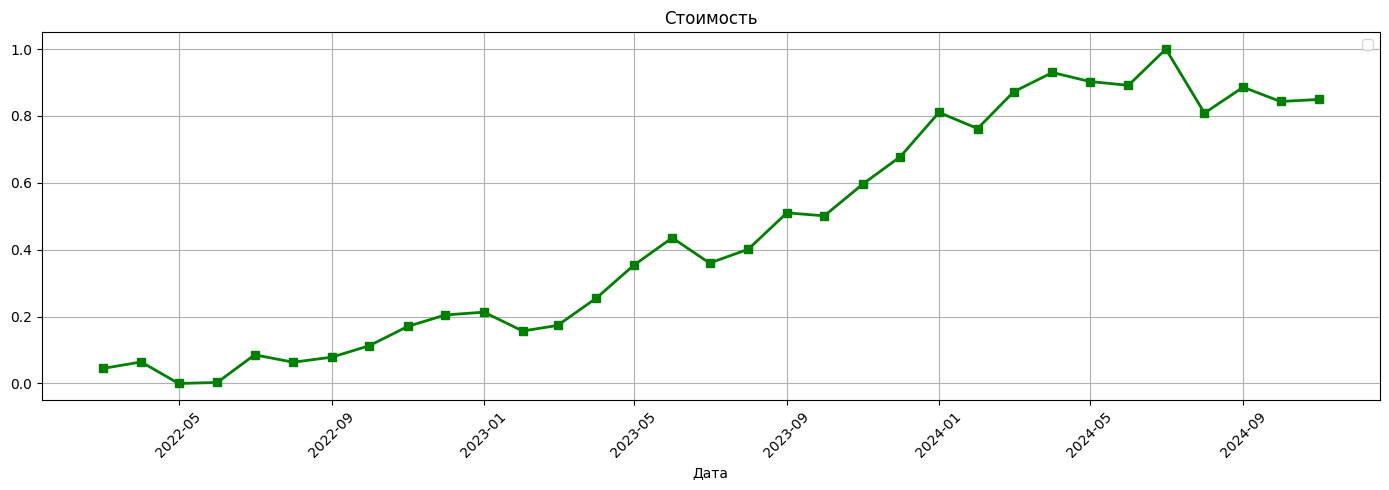

In [35]:
# Нормализация к диапазону [0, 1]
cost_data = test_target['cost_net__g_building__sale_cost__sum__1M']
test_target['cost_norm'] = (cost_data - cost_data.min()) / (cost_data.max() - cost_data.min())
# Построение графика
plt.figure(figsize=(14, 5))
plt.plot(
    test_target['report_date'], 
    test_target['cost_norm'],
    marker='s', 
    color='green', 
    linestyle='-', 
    linewidth=2
)

# Настройки графика
plt.title("Стоимость")
plt.xlabel("Дата")
plt.ylim(-0.05, 1.05)  # Добавляем небольшие отступы
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



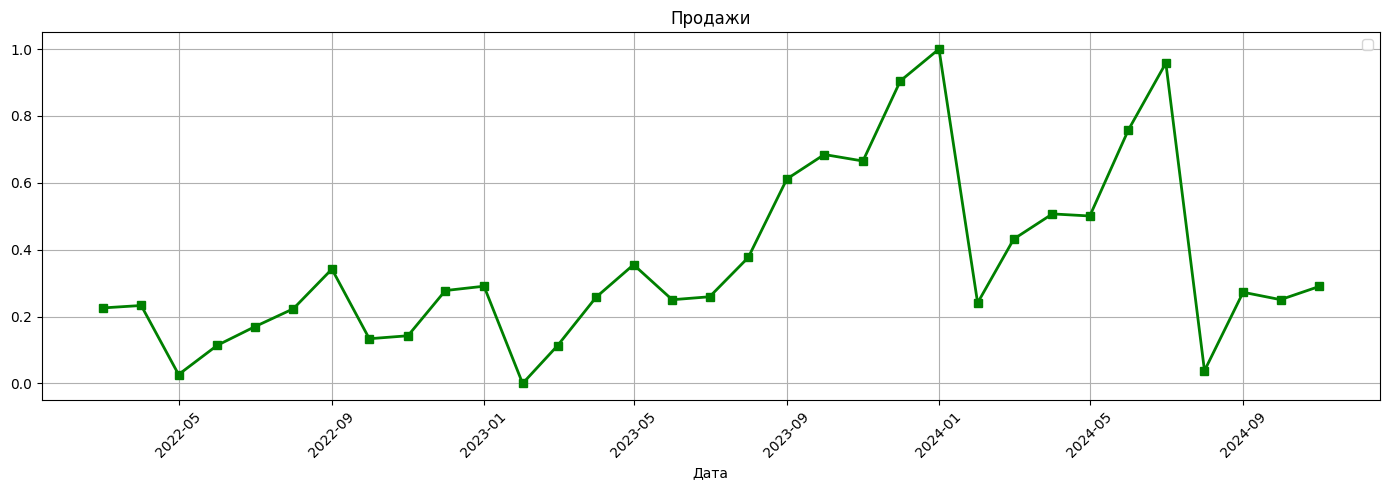

In [36]:
# Нормализация к диапазону [0, 1]
area_data = test_target['sales__g_building__smt_projected_total_area__sum__1M']
test_target['area_norm'] = (area_data - area_data.min()) / (area_data.max() - area_data.min())

# Сохраняем параметры нормализации для обратного преобразования
norm_params = {
    'min': area_data.min(),
    'max': area_data.max(),
    'range': area_data.max() - area_data.min()
}

# Построение графика
plt.figure(figsize=(14, 5))
plt.plot(
    test_target['report_date'], 
    test_target['area_norm'], 
    marker='s', 
    color='green', 
    linestyle='-', 
    linewidth=2
)

# Настройки графика
plt.title("Продажи")
plt.xlabel("Дата")
plt.ylim(-0.05, 1.05)  # Добавляем небольшие отступы
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

